# BLSLDA Profiling

In [1]:
from modules.helpers import plot_images
from functools import partial
from sklearn.metrics import (roc_auc_score, roc_curve)
import seaborn as sns

imshow = partial(plt.imshow, cmap='gray', interpolation='nearest', aspect='auto')
sns.set(style='white')

## Generate document-term matrix

In [2]:
V = 100
K = 10
N = 100
D = 1000
alpha = np.repeat(1., K)
beta = np.repeat(1., V)

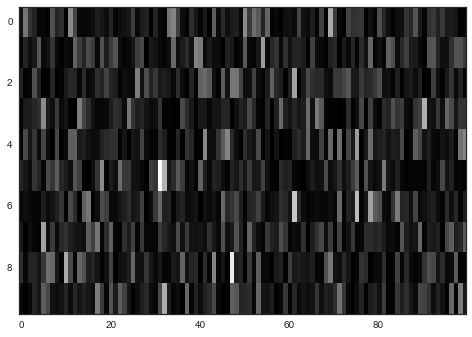

In [3]:
# generate phi
phi = np.random.RandomState(42).dirichlet(beta, size=K)
imshow(phi)

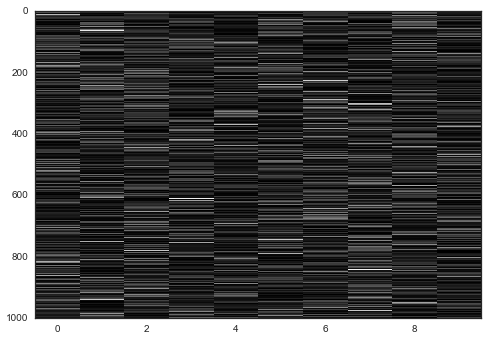

In [4]:
# generate theta
theta = np.random.RandomState(42).dirichlet(alpha, size=D)
imshow(theta)

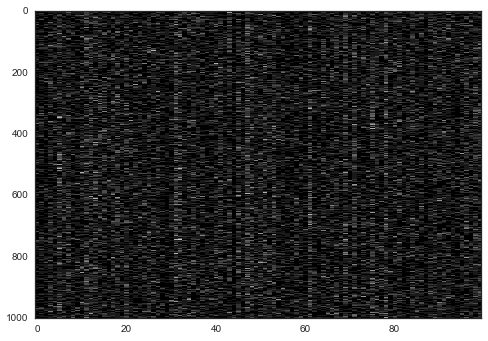

In [5]:
# generate document-term matrix
doc_term_matrix = np.zeros((D, V), dtype=np.int64)
rng = np.random.RandomState(42)
for d in range(D):
    topic_histogram = rng.multinomial(N, theta[d])
    for k in range(K):
        doc_term_matrix[d] += rng.multinomial(topic_histogram[k], phi[k])
imshow(doc_term_matrix)

### Generate responses

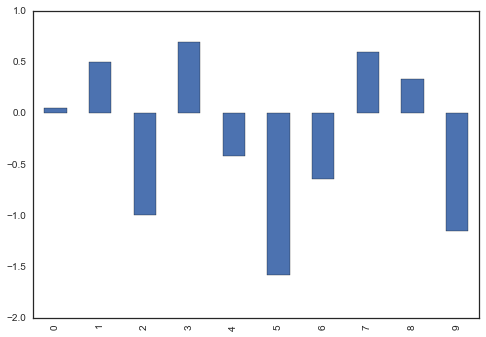

In [6]:
# choose parameter values
mu = 0.
nu2 = 1.
eta = np.random.RandomState(4).normal(loc=mu, scale=nu2, size=K)
pd.Series(eta).plot(kind='bar')

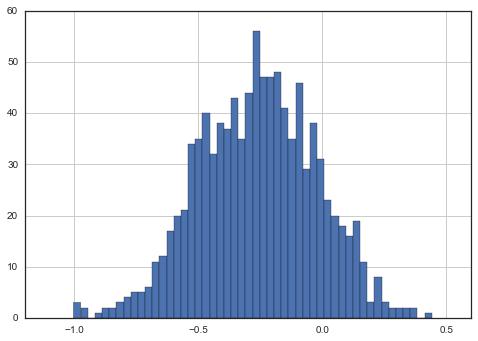

In [7]:
# plot histogram of pre-responses
zeta = np.array([np.dot(eta, theta[d]) for d in range(D)])
pd.Series(zeta).hist(bins=50)

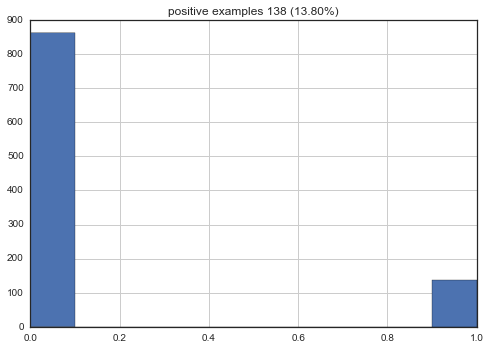

In [8]:
# set y
y = (zeta >= 0).astype(int)
# plot histogram of responses
pd.Series(y).hist()
plt.title('positive examples {} ({:.2f}%)'.format(y.sum(), y.sum() / D * 100))

### Estimate parameters

In [9]:
import pstats, cProfile
from lda_cython.topic_models import BLSLDA

In [10]:
_K = 10
_alpha = alpha
_beta = np.repeat(0.01, V)
_mu = mu
_nu2 = nu2
_b = 8
n_iter = 200
blslda = BLSLDA(_K, _alpha, _beta, _mu, _nu2, _b, n_iter, seed=42)

In [11]:
%%time
cProfile.runctx("blslda.fit(doc_term_matrix, y)", globals(), locals(), "Profile.prof")

2015-08-25 23:01:53.929901 start iterations
2015-08-25 23:01:54.410328 0:00:00.480427 elapsed, iter   10, LL -250839.0493, 13.35% change from last
2015-08-25 23:01:54.839207 0:00:00.909306 elapsed, iter   20, LL -238917.2485, 4.75% change from last
2015-08-25 23:01:55.257168 0:00:01.327267 elapsed, iter   30, LL -231327.6734, 3.18% change from last
2015-08-25 23:01:55.682587 0:00:01.752686 elapsed, iter   40, LL -225735.7314, 2.42% change from last
2015-08-25 23:01:56.117728 0:00:02.187827 elapsed, iter   50, LL -220733.3096, 2.22% change from last
2015-08-25 23:01:56.540373 0:00:02.610472 elapsed, iter   60, LL -216555.1285, 1.89% change from last
2015-08-25 23:01:56.961528 0:00:03.031627 elapsed, iter   70, LL -212642.5964, 1.81% change from last
2015-08-25 23:01:57.383279 0:00:03.453378 elapsed, iter   80, LL -211006.7754, 0.77% change from last
2015-08-25 23:01:57.815986 0:00:03.886085 elapsed, iter   90, LL -208124.3425, 1.37% change from last
2015-08-25 23:01:58.244966 0:00:04.31

In [12]:
s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("tottime").print_stats()

Tue Aug 25 23:02:02 2015    Profile.prof

         20018581 function calls in 8.556 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    7.086    7.086    8.550    8.550 _topic_models.pyx:497(gibbs_sampler_blslda)
 20000000    1.295    0.000    1.295    0.000 _topic_models.pyx:64(searchsorted)
      200    0.131    0.001    0.131    0.001 _topic_models.pyx:151(loglikelihood_blslda)
        1    0.008    0.008    0.008    0.008 _topic_models.pyx:33(create_rands)
      200    0.005    0.000    0.012    0.000 linalg.py:296(solve)
     1015    0.004    0.000    0.004    0.000 {built-in method array}
        1    0.002    0.002    0.002    0.002 {method 'nonzero' of 'numpy.ndarray' objects}
        8    0.002    0.000    0.002    0.000 {method 'repeat' of 'numpy.ndarray' objects}
        1    0.002    0.002    0.002    0.002 _topic_models.pyx:48(create_topic_lookup)
      811    0.002    0.000    0.002    0.000 stringsou

## other stuff

In [13]:
%%time
blslda.fit(doc_term_matrix, y)

2015-08-25 23:02:02.499818 start iterations
2015-08-25 23:02:02.816054 0:00:00.316236 elapsed, iter   10, LL -250839.0493, 13.35% change from last
2015-08-25 23:02:03.084356 0:00:00.584538 elapsed, iter   20, LL -238917.2485, 4.75% change from last
2015-08-25 23:02:03.369666 0:00:00.869848 elapsed, iter   30, LL -231327.6734, 3.18% change from last
2015-08-25 23:02:03.656577 0:00:01.156759 elapsed, iter   40, LL -225735.7314, 2.42% change from last
2015-08-25 23:02:03.937644 0:00:01.437826 elapsed, iter   50, LL -220733.3096, 2.22% change from last
2015-08-25 23:02:04.223371 0:00:01.723553 elapsed, iter   60, LL -216555.1285, 1.89% change from last
2015-08-25 23:02:04.503353 0:00:02.003535 elapsed, iter   70, LL -212642.5964, 1.81% change from last
2015-08-25 23:02:04.780910 0:00:02.281092 elapsed, iter   80, LL -211006.7754, 0.77% change from last
2015-08-25 23:02:05.061101 0:00:02.561283 elapsed, iter   90, LL -208124.3425, 1.37% change from last
2015-08-25 23:02:05.347142 0:00:02.84

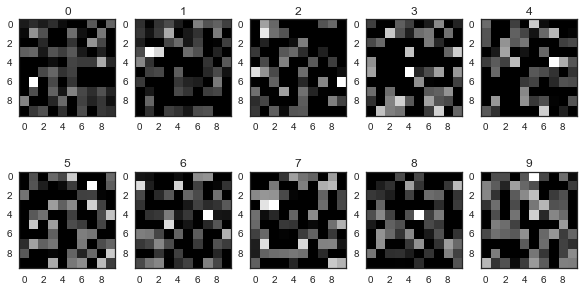

In [14]:
plot_images(plt, blslda.phi, (10, 10), (2, 5), figsize=(10, 5))

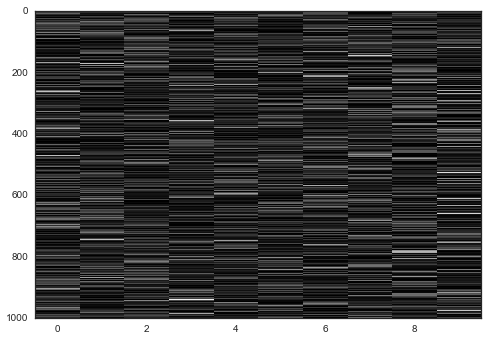

In [15]:
imshow(blslda.theta)

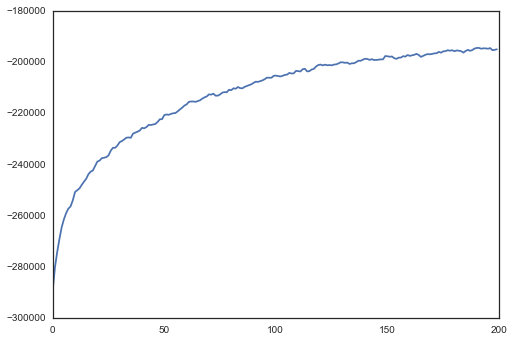

In [16]:
plt.plot(blslda.loglikelihoods)

In [17]:
burn_in = 100
eta_pred = blslda.eta[burn_in:].mean(axis=0)
print('mean log-likelihood {}'.format(blslda.loglikelihoods[burn_in:].mean()))
eta_pred

mean log-likelihood -198916.3680838434


array([ -7.65792495,  -8.81479835,  -7.21599757,   5.49959948,
        -4.39817516,  -5.01795172,  -7.74796161,  -7.27304832,
        -8.34087661,  14.49302745])